Author: J. D. Camacho

# Keras Auto Compressor module

This notebook was designed as an example to test the `keras_autocompressor` python
module. 

Following our paper strage

In [1]:
# Import basic modules
import tensorflow as tf
import keras_tuner as kt
import tensorflow_datasets as tfds

# Allow memory grwoth in the docker container
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
# Change current directory to load our custom module
%cd /app/

/app


In [3]:
# Import the hyper model for the auto compression task
from keras_autocompressor.hypermodels import HyperAutoCompressMobileNetV2

In [4]:
# Experiment settings
tensorflow_dataset = 'horses_or_humans'
batch_size = 8
max_search_epochs = 5

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    tensorflow_dataset, 
    split=['train', 'test'], 
    shuffle_files=True, 
    with_info=True, 
    as_supervised=True
)

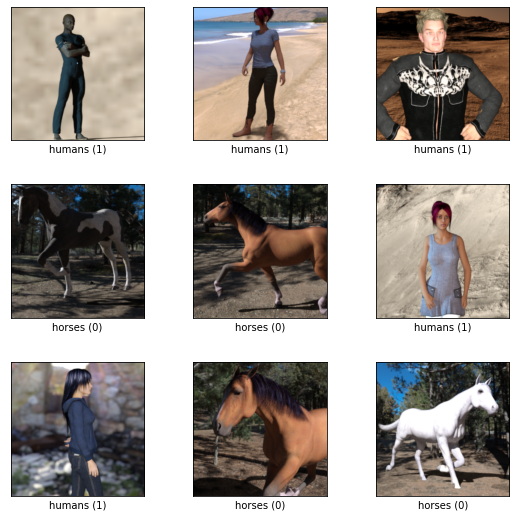

In [6]:
fig = tfds.show_examples(ds_train, ds_info)

In [7]:
def preprocess_images(
        image, 
        label, 
        num_classes=ds_info.features['label'].num_classes
    ):
    # Resize images
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224,224))

    # Preprocess with the MobileNet function
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)

    # Change labels to categorical
    label = tf.cast(
        tf.one_hot(tf.cast(label, tf.int32), num_classes), dtype=tf.float32
    )
    
    return image, label

In [8]:
# Pre-process the images
ds_train = ds_train.map(preprocess_images, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess_images, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
# Create batches for inference in both subsets
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)   

ds_test = ds_test.batch(batch_size)

In [10]:
# Create our Hyper model
HyperModel = HyperAutoCompressMobileNetV2(
    max_parameters=2309581,
    num_classes=ds_info.features['label'].num_classes,
    tau=0.4,
)

# Create the tuner object for our search
mobilenetv2_compressor = kt.Hyperband(
    HyperModel,
    max_epochs=max_search_epochs,
    objective=kt.Objective("val_acc_comp", direction="max"),
    directory='./logs/mobilenetv2/',
    project_name=tensorflow_dataset,
    overwrite=True
)

In [11]:
# Run the hyperparameters search + auto compression
mobilenetv2_compressor.search(ds_train, validation_data=ds_test)

Trial 10 Complete [00h 00m 13s]
val_acc_comp: 0.6018407344818115

Best val_acc_comp So Far: 0.6364171504974365
Total elapsed time: 00h 02m 56s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [12]:
# Get the best hyper parameters after the search
best_hyperparameters = mobilenetv2_compressor.get_best_hyperparameters()[0]
print(best_hyperparameters.values)

{'translator': '97,151', 'top_fc1_units': 4, 'lr': 0.00035496969336523644, 'tuner/epochs': 5, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [13]:
# Get the best model
best_model = mobilenetv2_compressor.get_best_models()[0]

In [14]:
# Compute the performance for the top-5 models obtained
for idx, sub_model in enumerate(mobilenetv2_compressor.get_best_models(5), start=1):
    metrics = sub_model.evaluate(ds_test, verbose=0)
    print(f'Top-{idx} model | val_accuracy: {metrics[1]:0.4f}  | params:' \
          + f' {sub_model.count_params()}')

Top-1 model | val_accuracy: 0.5898  | params: 768014
Top-2 model | val_accuracy: 0.6523  | params: 920070
Top-3 model | val_accuracy: 0.5391  | params: 788542
Top-4 model | val_accuracy: 0.5312  | params: 788542
Top-5 model | val_accuracy: 0.6406  | params: 977654


In [15]:
# Display the top-3 best models and their hyperparameters within the search
mobilenetv2_compressor.results_summary(num_trials=3)

Results summary
Results in ./logs/mobilenetv2/horses_or_humans
Showing 3 best trials
Objective(name='val_acc_comp', direction='max')
Trial summary
Hyperparameters:
translator: 97,151
top_fc1_units: 4
lr: 0.00035496969336523644
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.6364171504974365
Trial summary
Hyperparameters:
translator: 17,143
top_fc1_units: 12
lr: 0.0022852654637537527
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.6219149231910706
Trial summary
Hyperparameters:
translator: 97,151
top_fc1_units: 20
lr: 0.00010503097274516056
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.6107717752456665
